# Example User

In [1]:
import pandas as pd
import numpy as np
import datetime
import networkx as nx
import nxpd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [2]:
# Load and preprocess data
otc_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinotc.csv.gz')
alpha_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinalpha.csv.gz')
alpha_users = h.user_activity_dataframe(alpha_df)
otc_users = h.user_activity_dataframe(otc_df)

In [3]:
# Load graph objects
alpha_G = h.build_graph('alpha', alpha_df)
alpha_pos_G = h.build_graph('alpha', alpha_df, rating_type='pos')
otc_G = h.build_graph('otc',otc_df)
otc_pos_G = h.build_graph('otc',otc_df, rating_type='pos')

In [4]:
df_otc_features = pd.read_csv('../data/df_features_otc.csv')
df_otc_velocity = pd.read_csv('../data/df_otc_vd.csv')

merge_cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(df_otc_features, df_otc_velocity, on=merge_cols)

features_df.drop(['binomial_rating', 'color', 'penwidth'], inplace=True, axis=1)

## Project Example

       rater  ratee  rating                date  class  binomial_rating color  \
28678   2296   4986       1 2013-11-05 16:19:37      0                1  blue   
28679   4986   2296       1 2013-11-05 16:20:43      0                1  blue   
28699   4986   4983       1 2013-11-06 15:56:53      0                1  blue   
28701   4983   4986       1 2013-11-06 16:00:20      0                1  blue   
28707   3714   4986       1 2013-11-06 19:38:49      0                1  blue   
28708   4986   3714       1 2013-11-06 21:06:15      0                1  blue   
28717   4986   4991       1 2013-11-07 08:42:52      0                1  blue   
28718   4991   4986       1 2013-11-07 08:43:21      0                1  blue   
28721   1334   4986       1 2013-11-07 12:04:56      0                1  blue   
28729   1810   4986      -8 2013-11-08 08:16:31      1               -1   red   
28731   4172   4986     -10 2013-11-08 11:49:19      1               -1   red   

       penwidth  
28678    

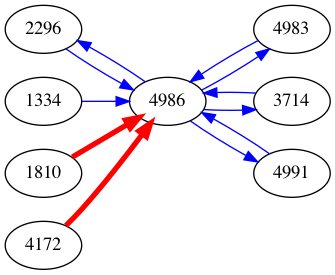

In [170]:
user = 4986

user_df = h.user_data('otc', otc_df, user_type='all', rating_type='all', user=user)#, max_date=date)
user_g = h.build_graph('otc', otc_df, user_lst=[user])
print(user_df)
user_g.graph['rankdir']='LR'
nxpd.draw(user_g, show='ipynb')

In [83]:
maxdate='2012-09-25'
alpha_df[(alpha_df['date'] <= maxdate) & (alpha_df['ratee']==7536)]

,rater,ratee,rating,date,class,binomial_rating,color,penwidth
8044,30,7536,-10,2012-09-24 21:00:00,1,-1,red,4
15841,145,7536,-10,2012-09-24 21:00:00,1,-1,red,4
24136,7517,7536,10,2012-09-24 21:00:00,0,1,blue,4
24148,7565,7536,10,2012-09-24 21:00:00,0,1,blue,4


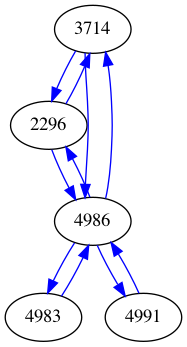

In [112]:
user = 4986
user_g = nx.ego_graph(otc_pos_G, user, radius=1)
user_g.graph['rankdir']='TB'
nxpd.draw(user_g, show='ipynb')

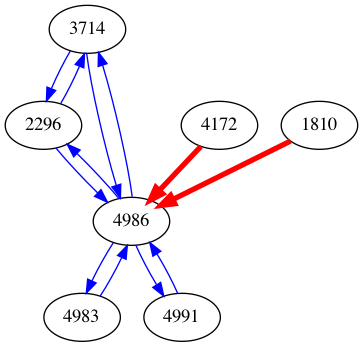

In [113]:
user = 4986
user_g = nx.ego_graph(otc_pos_G, user, radius=1)
user_g.graph['rankdir']='TB'
user_g.add_edges_from([(4172,4986), (1810,4986)], color='red', penwidth=4)
nxpd.draw(user_g, show='ipynb')

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [120]:
df_otc_features = pd.read_csv('../data/df_features_otc.csv')
df_otc_velocity = pd.read_csv('../data/df_otc_vd.csv')

merge_cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(df_otc_features, df_otc_velocity, on=merge_cols)

features_df.drop(['binomial_rating', 'color', 'penwidth'], inplace=True, axis=1)

In [121]:
graph_cols = ['ego_triad_300', 'ego_triad_210', 'ego_triad_201', 
              'ego_triad_120', 'ego_triad_all', 'ego_cluster_coef', 
              'ego_degree', 'ego_betweeness', 'ego_closeness', 'ego_num_cliques']
features_df_ng = features_df.copy()
features_df_ng.drop(graph_cols, inplace=True, axis=1)

X = features_df_ng.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
r = X['rating_received_avg']
y = X.pop('class')
X_train, X_test, y_train, y_test, r_train, r_test = train_test_split(X, y, r, 
                                                    stratify=y, shuffle=True,
                                                    random_state=1)
model_nograph = RandomForestClassifier(n_jobs=-1, random_state=1)
model_nograph.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [122]:
x_pred = features_df_ng[(features_df_ng['ratee']==4986)].copy()

x = x_pred.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = x.pop('class')

# run model without graph features
pred_no_features = model_nograph.predict_proba(x)[:,1]
x_pred = x_pred[['ratee','date','rating']]
x_pred['prediction_without_features'] = pred_no_features

In [124]:
X = features_df.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
r = X['rating_received_avg']
y = X.pop('class')
X_train, X_test, y_train, y_test, r_train, r_test = train_test_split(X, y, r,
                                                    stratify=y, shuffle=True,
                                                    random_state=1)
model = RandomForestClassifier(n_jobs=-1, random_state=1)
model.fit(X_train, y_train)

# rerun model with graph features
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date'], axis=1, inplace=True)
y = x.pop('class')

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features
x_pred

,ratee,date,rating,prediction_without_features,prediction_with_features
28678,4986,2013-11-05 16:19:37,1,0.067570,0.067570
28701,4986,2013-11-06 16:00:20,1,0.067916,0.067916
28707,4986,2013-11-06 19:38:49,1,0.032693,0.025126
28718,4986,2013-11-07 08:43:21,1,0.000000,0.000000
28721,4986,2013-11-07 12:04:56,1,0.000000,0.000000
28729,4986,2013-11-08 08:16:31,-8,0.342667,0.550000
28731,4986,2013-11-08 11:49:19,-10,0.980000,0.960000


In [126]:
x_pred.to_csv("../data/example_prediction.csv", index=False)

### Example of collusion fraud

In [ ]:
# Example 1
example_user = X[(features_df['ratee']==4986)].copy()
preds = RF.predict_proba(example_user)[:,1]
example_user['prediction'] = preds
example_user.to_csv()

In [ ]:
#Example 2
example_user = X[(features_df['ratee']==4524)].copy()
preds = RF.predict_proba(example_user)[:,1]
example_user['prediction'] = preds
example_user[:10]